In [12]:
!pip install mne
!pip install mosek

In [13]:
#Run this cell to set up imports

from IPython.display import display, Math
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import Ridge, Lasso
from statsmodels.tsa.seasonal import seasonal_decompose
import cvxpy as cp
import mne
import mosek
from scipy import stats

# STAT 153: Time Series Homework Four
## Due Date: Tuesday, April 14th, 11:59 P.M.

# Scoring Breakdown (Undergraduate)
|Question|Points|
|---|---|
|1a|2|
|1b|6|
|1c|4|
|2a|3|
|2b|4|
|2c|4|
|2d|4|
|3|10|
|4a|3|
|4b|3|
|4c|3|
|4d|3|
|4e|4|
|4f|3|
|4g|4|
|4h|4|
|4i|2|
|5a|4|
|5b|4|
|5c|4|
|6a|1|
|6b|2|
|6c|3|
|6d|1|
|**Total**|85|

## 1a)

In [14]:
raw_eyes_open = mne.io.read_raw_edf('S001R01.edf', preload = True)
raw_eyes_closed = mne.io.read_raw_edf('S001R02.edf', preload = True)
raw_task = mne.io.read_raw_edf('S001R05.edf', preload = True)

Extracting EDF parameters from /home/jovyan/STAT153/S001R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Extracting EDF parameters from /home/jovyan/STAT153/S001R02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Extracting EDF parameters from /home/jovyan/STAT153/S001R05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...


<Info | 8 non-empty values
 bads: []
 ch_names: Fc5., Fc3., Fc1., Fcz., Fc2., Fc4., Fc6., C5.., C3.., C1.., ...
 chs: 64 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 80.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 64
 projs: []
 sfreq: 160.0 Hz
 subject_info: <subject_info | his_id: X, sex: 0, last_name: X>
>


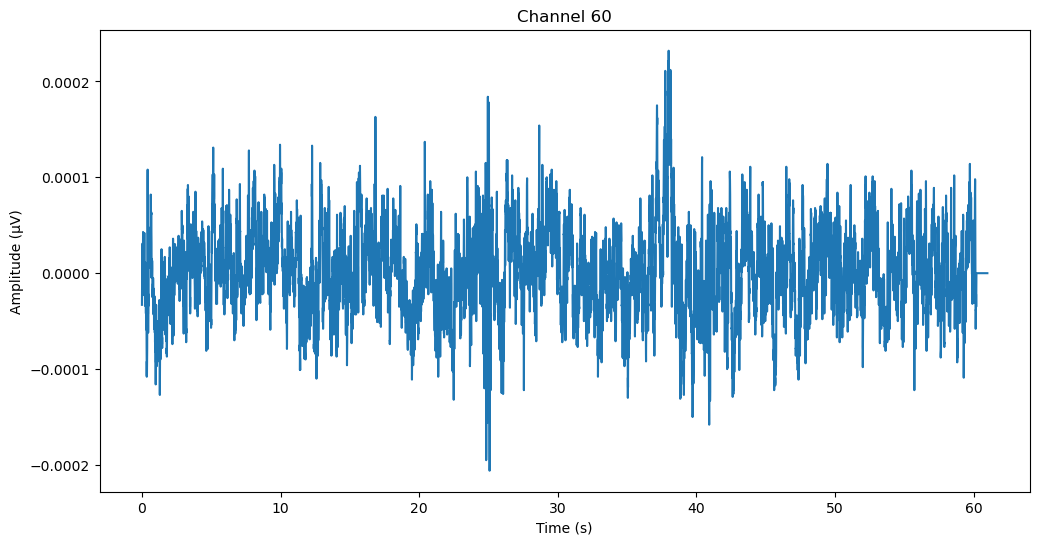

In [15]:
# Eyes open
print(raw_eyes_open.info)
data_1, times_1 = raw_eyes_open[:]

ch_index = 59  # pick a channel, # Channel 60 = index 59 
plt.figure(figsize=(12,6))
plt.plot(times_1, data_1[ch_index, :])
plt.title(f"Channel {ch_index+1}")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (µV)")
plt.show()

<Info | 8 non-empty values
 bads: []
 ch_names: Fc5., Fc3., Fc1., Fcz., Fc2., Fc4., Fc6., C5.., C3.., C1.., ...
 chs: 64 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 80.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 64
 projs: []
 sfreq: 160.0 Hz
 subject_info: <subject_info | his_id: X, sex: 0, last_name: X>
>


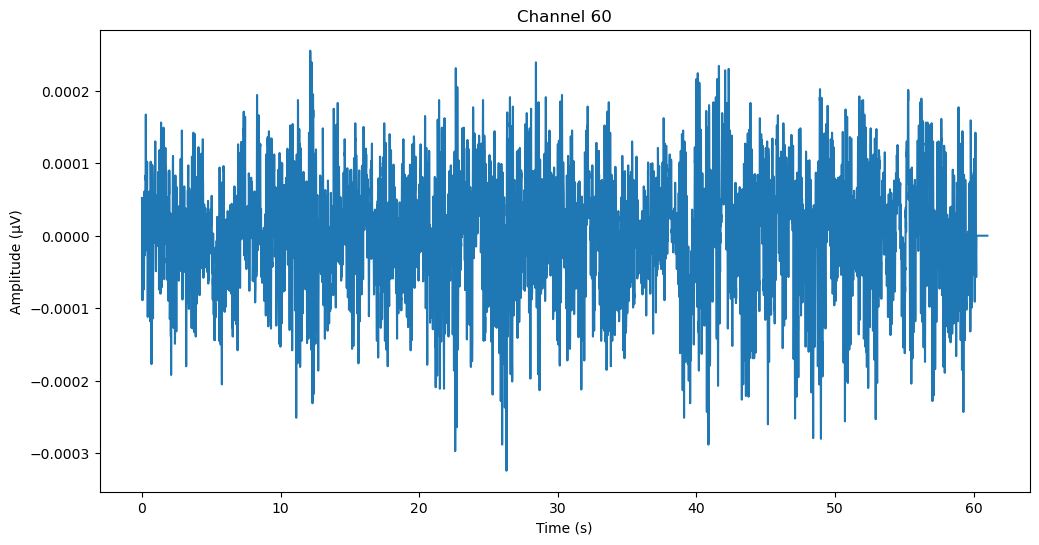

In [16]:
# Eyes closed
print(raw_eyes_closed.info)
data_2, times_2 = raw_eyes_closed[:]

ch_index = 59  # pick a channel, # Channel 60 = index 59 
plt.figure(figsize=(12,6))
plt.plot(times_2, data_2[ch_index, :])
plt.title(f"Channel {ch_index+1}")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (µV)")
plt.show()

<Info | 8 non-empty values
 bads: []
 ch_names: Fc5., Fc3., Fc1., Fcz., Fc2., Fc4., Fc6., C5.., C3.., C1.., ...
 chs: 64 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 80.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 64
 projs: []
 sfreq: 160.0 Hz
 subject_info: <subject_info | his_id: X, sex: 0, last_name: X>
>


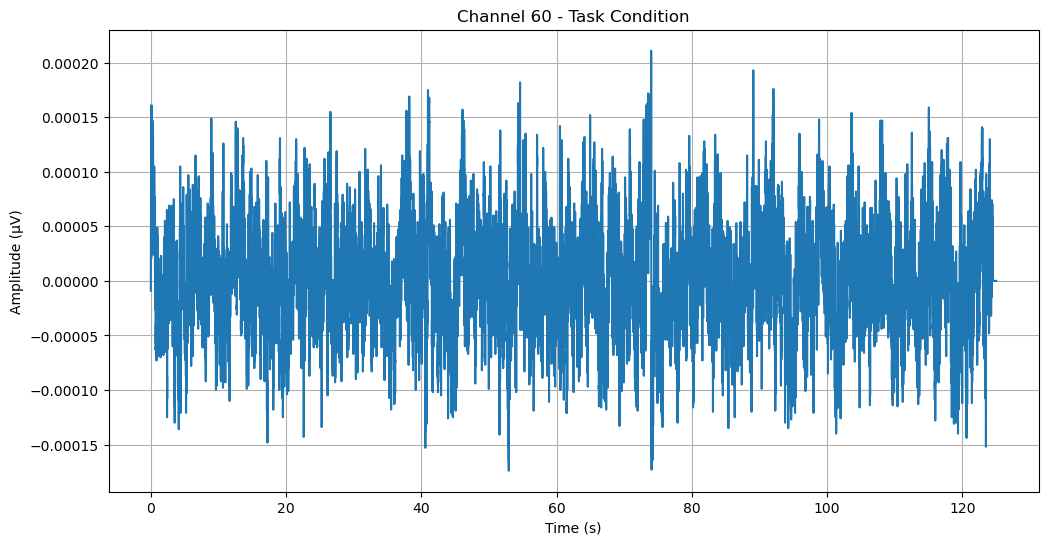

In [17]:
# Eyes open task
print(raw_task.info)
data_3, times_3 = raw_task[:]

ch_index = 59  # pick a channel, # Channel 60 = index 59
plt.figure(figsize=(12, 6))
plt.plot(times_3, data_3[ch_index, :])
plt.title(f"Channel {ch_index + 1} - Task Condition")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (µV)")
plt.grid(True)
plt.show()

In [18]:
#Let us check if the time series are equally spaced
print(np.diff(times_1))
print(np.diff(times_2))
print(np.diff(times_3))
#Let us check if the lengths of the three time series ('eyes open' and 'eyes closed', 'eyes open task') are the same
print(len(times_1))
print(len(times_2))
print(len(times_3))

[0.00625 0.00625 0.00625 ... 0.00625 0.00625 0.00625]
[0.00625 0.00625 0.00625 ... 0.00625 0.00625 0.00625]
[0.00625 0.00625 0.00625 ... 0.00625 0.00625 0.00625]
9760
9760
20000


In [19]:
y_o = data_1[ch_index, :]
y_c = data_2[ch_index, :]
y_t = data_3[ch_index, :]

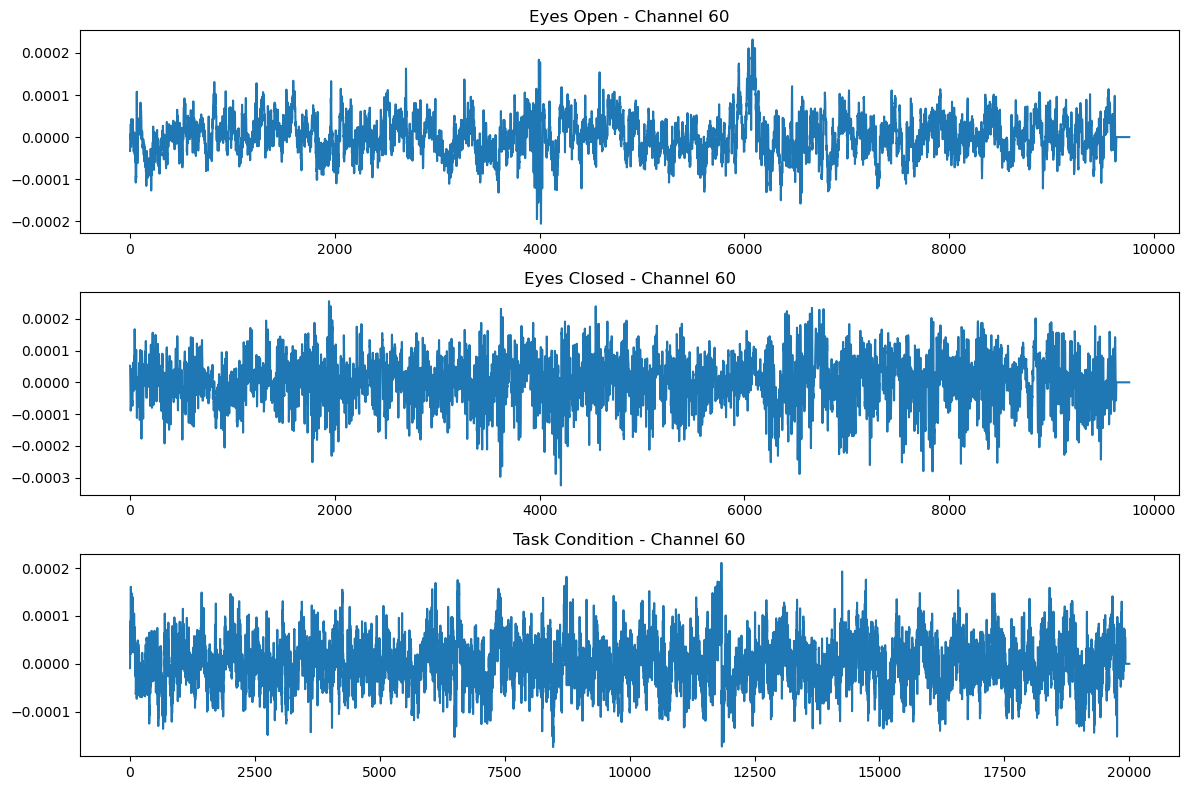

In [20]:
fig, axes = plt.subplots(nrows = 3, ncols = 1, figsize = (12, 8))

axes[0].plot(y_o)
axes[0].set_title('Eyes Open - Channel 60')

axes[1].plot(y_c)
axes[1].set_title('Eyes Closed - Channel 60')

axes[2].plot(y_t)
axes[2].set_title('Task Condition - Channel 60')

plt.tight_layout()
plt.show()

#### Interpretation

The eyes open time series displays oscillations with moderate frequency and relatively consistent amplitude, primarily bounded within $\pm 0.0002~\mu \text{V}$. The waveform appears smooth, with clear peaks and troughs that are spaced farther apart compared to other states. The eyes closed time series exhibits higher-frequency oscillations, with more densely packed peaks and troughs across the same time window. The amplitude range is slightly larger, extending to approximately $\pm 0.0003~\mu \text{V}$. The pattern appears more regular and tightly clustered than in the eyes open condition. The task condition time series spans a longer duration and displays greater variability in oscillation patterns. While the frequency of oscillations varies across the signal, the amplitude appears slightly reduced remaining mostly within $\pm 0.0002~\mu\text{V}$. The waveform includes periods of relatively low variation with brief bursts of higher activity.

## 1b)

In [21]:
def periodogram(y):
    fft_y = np.fft.fft(y)
    n = len(y)
    fourier_freqs = np.arange(1/n, 1/2, 1/n)
    m = len(fourier_freqs)
    pgram_y = (np.abs(fft_y[1:m+1]) ** 2)/n
    return fourier_freqs, pgram_y

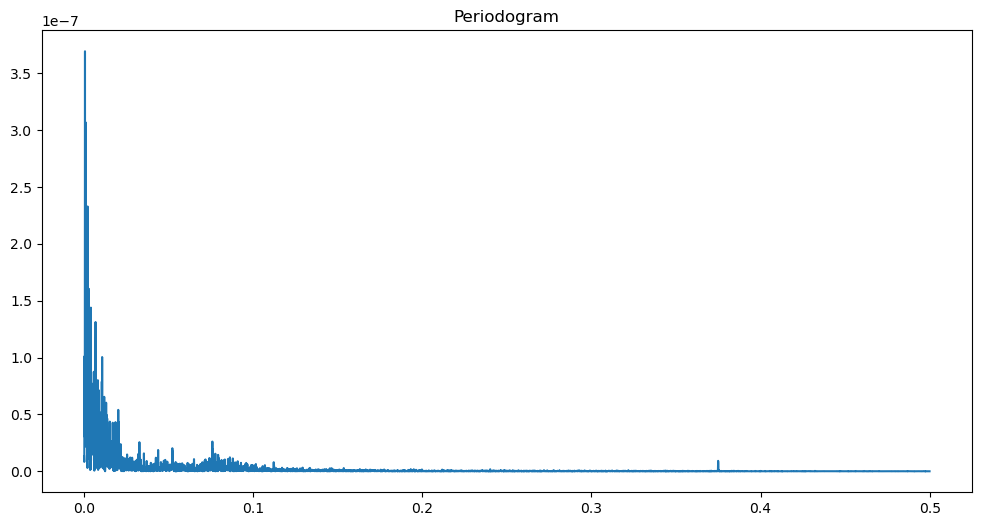

In [22]:
# Compute periodogram for eyes open data
freqs, pgram_o = periodogram(y_o)
plt.figure(figsize = (12, 6))
plt.plot(freqs, pgram_o)
plt.title('Periodogram')
plt.show()

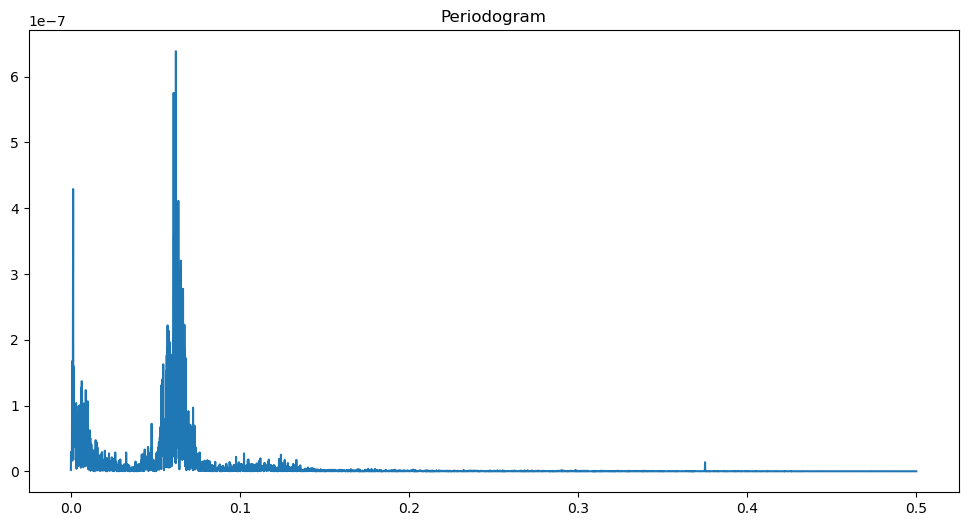

In [23]:
# Compute periodogram for eyes closed data
freqs, pgram_c = periodogram(y_c)
plt.figure(figsize = (12, 6))
plt.plot(freqs, pgram_c)
plt.title('Periodogram')
plt.show()

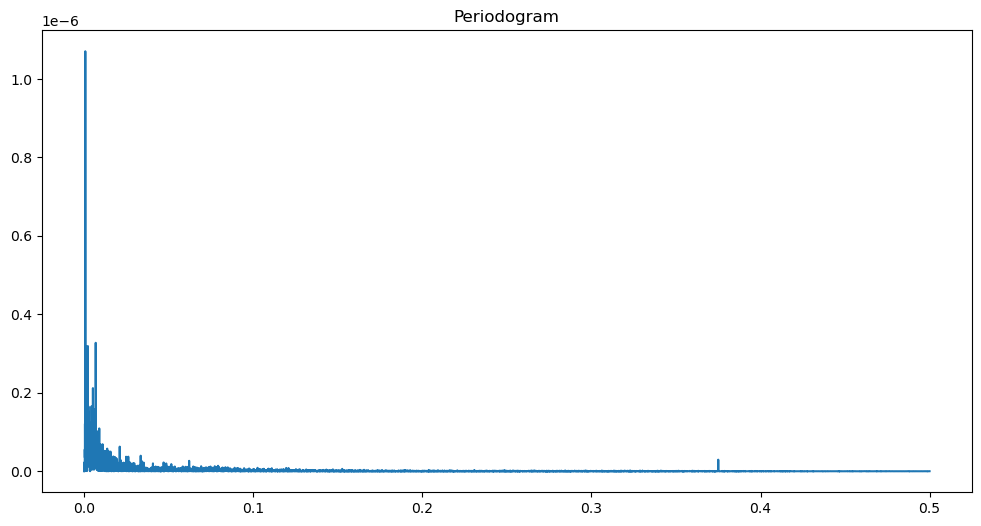

In [24]:
# Compute periodogram for eyes open and task data
freqs, pgram_t = periodogram(y_t)
plt.figure(figsize = (12, 6))
plt.plot(freqs, pgram_t)
plt.title('Periodogram')
plt.show()

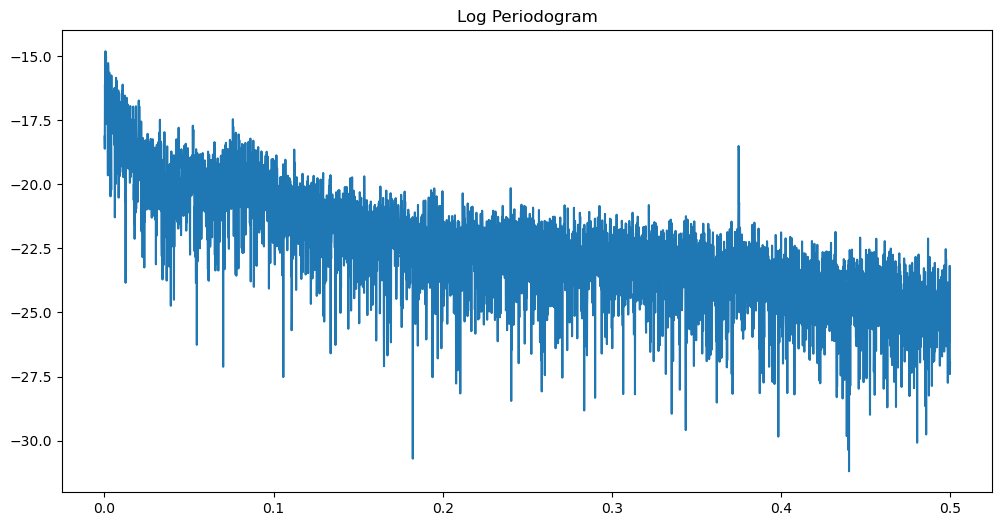

In [25]:
#Compute log periodogram for eyes open data
freqs, pgram_o = periodogram(y_o)
plt.figure(figsize = (12, 6))
plt.plot(freqs, np.log(pgram_o))
plt.title('Log Periodogram')
plt.show()

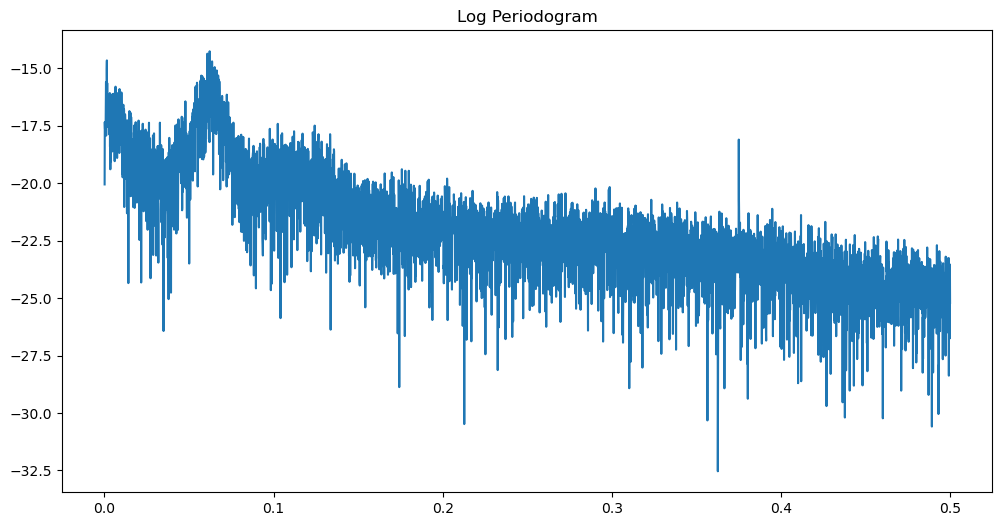

In [26]:
#Compute log periodogram for eyes closed data
freqs, pgram_c = periodogram(y_c)
plt.figure(figsize = (12, 6))
plt.plot(freqs, np.log(pgram_c))
plt.title('Log Periodogram')
plt.show()

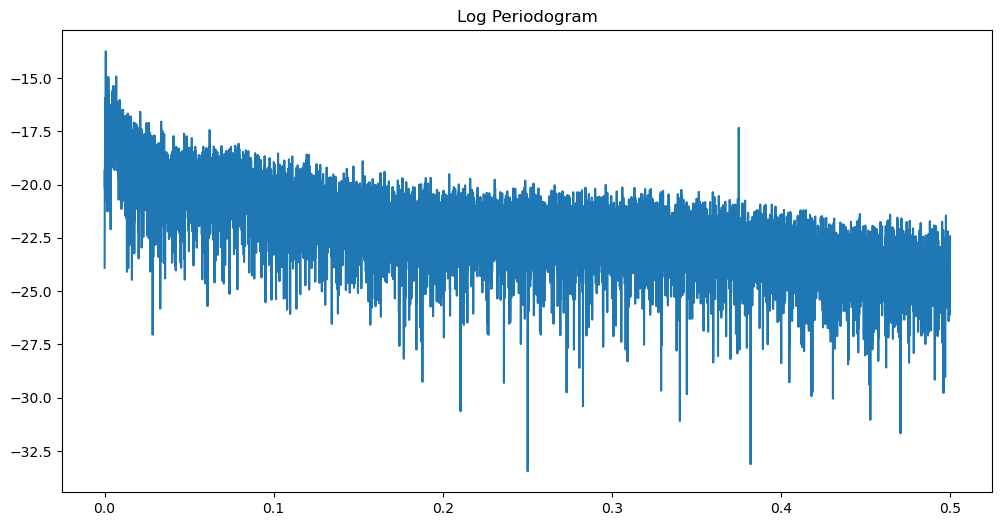

In [27]:
#Compute log periodogram for eyes open and task data
freqs, pgram_t = periodogram(y_t)
plt.figure(figsize = (12, 6))
plt.plot(freqs, np.log(pgram_t))
plt.title('Log Periodogram')
plt.show()

In [28]:
#Compute regularization techniques for Spectral Model
def spectrum_estimator_ridge(y, lambda_val):
    freq, I = periodogram(y)
    m = len(freq)
    n = len(y)
    alpha = cp.Variable(m)
    neg_likelihood_term = cp.sum(cp.multiply((n * I / 2), cp.exp(-2 * alpha)) + 2*alpha)
    smoothness_penalty = cp.sum(cp.square(alpha[2:] - 2 * alpha[1:-1] + alpha[:-2]))
    objective = cp.Minimize(neg_likelihood_term + lambda_val * smoothness_penalty)
    problem = cp.Problem(objective)
    problem.solve(solver = cp.MOSEK)
    return alpha.value, freq

def spectrum_estimator_lasso(y, lambda_val):
    freq, I = periodogram(y)
    m = len(freq)
    n = len(y) 
    alpha = cp.Variable(m)
    neg_likelihood_term = cp.sum(cp.multiply((n * I / 2), cp.exp(-2 * alpha)) + 2*alpha)
    smoothness_penalty = cp.sum(cp.abs(alpha[2:] - 2 * alpha[1:-1] + alpha[:-2]))
    objective = cp.Minimize(neg_likelihood_term + lambda_val * smoothness_penalty)
    problem = cp.Problem(objective)
    problem.solve(solver = cp.MOSEK)
    return alpha.value, freq

In [29]:
n_o = len(y_o)
freqs, pgram_o = periodogram(y_o)
alpha_opt_ridge_o, freq = spectrum_estimator_ridge(y_o, 1000000)
pgram_mean_ridge_o = (2/n_o)*(np.exp(2*alpha_opt_ridge_o))
alpha_opt_lasso_o, freq = spectrum_estimator_lasso(y_o, 1000)
pgram_mean_lasso_o = (2/n_o)*(np.exp(2*alpha_opt_lasso_o))

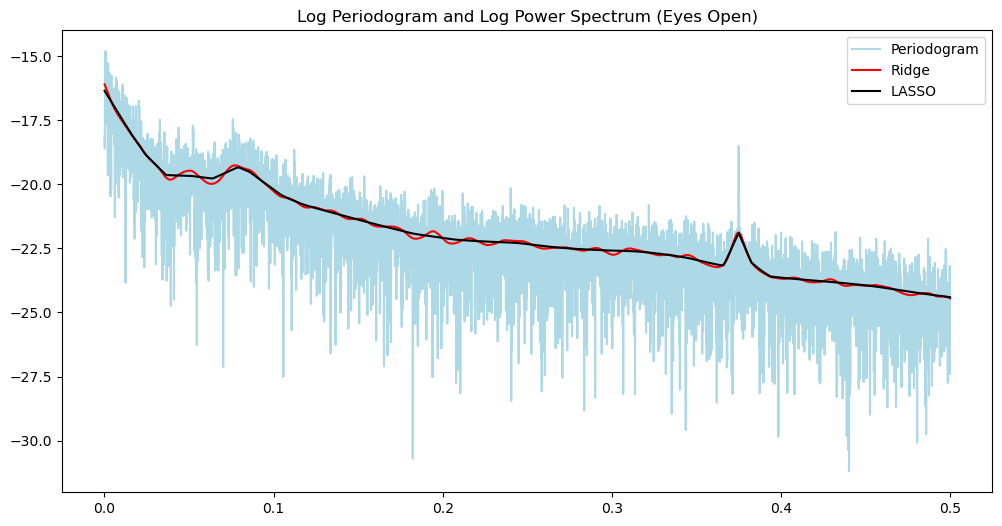

In [30]:
plt.figure(figsize = (12, 6))
plt.plot(freqs, np.log(pgram_o), color = 'lightblue', label = 'Periodogram')
plt.title('Log Periodogram and Log Power Spectrum (Eyes Open)')
plt.plot(freqs, np.log(pgram_mean_ridge_o), color = 'red', label = 'Ridge')
plt.plot(freqs, np.log(pgram_mean_lasso_o), color = 'black', label = 'LASSO')
plt.legend()
plt.show()

In [31]:
n_c = len(y_c)
freqs, pgram_c = periodogram(y_c)
alpha_opt_ridge_c, freq = spectrum_estimator_ridge(y_c, 1000000)
pgram_mean_ridge_c = (2/n_c)*(np.exp(2*alpha_opt_ridge_c))
alpha_opt_lasso_c, freq = spectrum_estimator_lasso(y_c, 1000)
pgram_mean_lasso_c = (2/n_c)*(np.exp(2*alpha_opt_lasso_c))

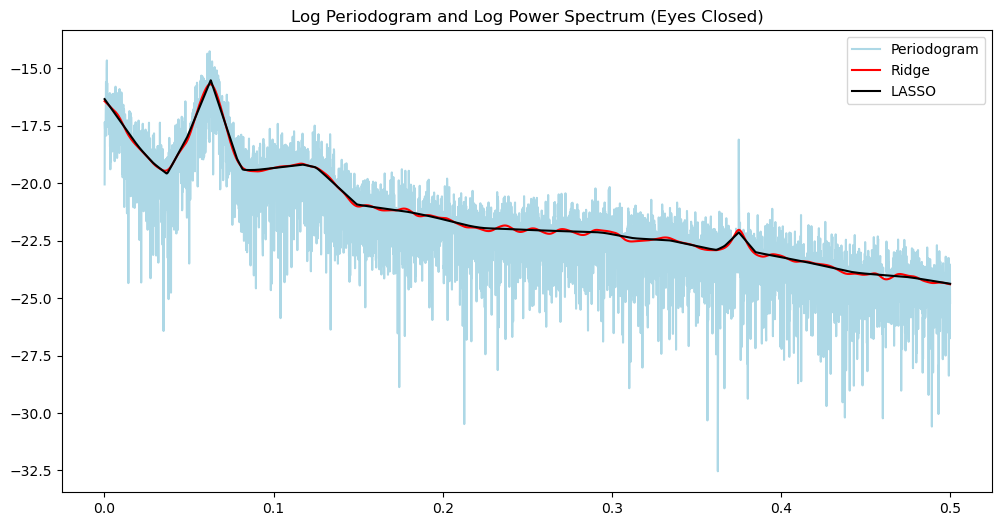

In [32]:
plt.figure(figsize = (12, 6))
plt.plot(freqs, np.log(pgram_c), color = 'lightblue', label = 'Periodogram')
plt.title('Log Periodogram and Log Power Spectrum (Eyes Closed)')
plt.plot(freqs, np.log(pgram_mean_ridge_c), color = 'red', label = 'Ridge')
plt.plot(freqs, np.log(pgram_mean_lasso_c), color = 'black', label = 'LASSO')
plt.legend()
plt.show()

In [33]:
n_t = len(y_t)
freqs, pgram_t = periodogram(y_t)
alpha_opt_ridge_t, freq = spectrum_estimator_ridge(y_t, 1000000)
pgram_mean_ridge_t = (2/n_t)*(np.exp(2*alpha_opt_ridge_t))
alpha_opt_lasso_t, freq = spectrum_estimator_lasso(y_t, 1000)
pgram_mean_lasso_t = (2/n_t)*(np.exp(2*alpha_opt_lasso_t))

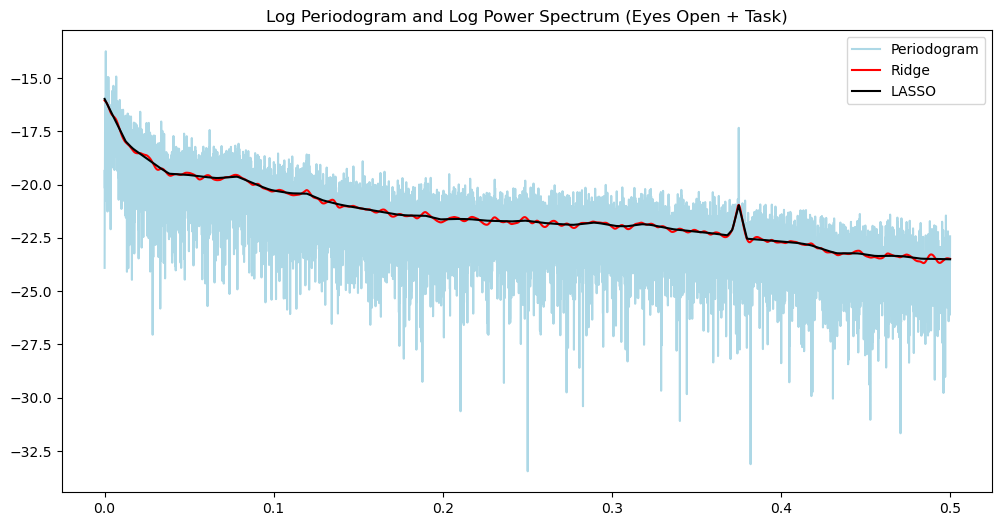

In [34]:
plt.figure(figsize = (12, 6))
plt.plot(freqs, np.log(pgram_t), color = 'lightblue', label = 'Periodogram')
plt.title('Log Periodogram and Log Power Spectrum (Eyes Open + Task)')
plt.plot(freqs, np.log(pgram_mean_ridge_t), color = 'red', label = 'Ridge')
plt.plot(freqs, np.log(pgram_mean_lasso_t), color = 'black', label = 'LASSO')
plt.legend()
plt.show()

### Description

For each of the three EEG time series ("Eyes Open", "Eyes Closed", and "Eyes Open + Task"), we estimated the power spectral density (PSD) using both the periodogram and regularized estimators. The results are visualized on a logarithmic scale for interpretability. We began by computing the periodogram for each time series using the periodogram function from scipy.signal. This provides a raw estimate of the spectral density but is often noisy. To regularize the estimation, we used two smoothing techniques, Ridge regression (L2 regularization) and LASSO regression (L1 regularization). These techniques involve minimizing a penalized version of the negative log-likelihood. The penalty promotes smoothness in the estimated log-spectrum. The LASSO technique with a lambda value of 1000 was chosen because it provided the smoothest curve and still captured the noise very well. Lambda equal to 10000 results in a line that was almost completely straight, and lambda equal to 100 resulted in a curve wasn't smooth at any point. 

Each figure displays the log-periodogram (light blue) and the regularized PSD estimates using Ridge (red) and LASSO (black). For the eyes open time series, the spectral density gradually decays with frequency. The LASSO estimate tracks the trend more tightly and suppresses noise more aggressively than Ridge. For the eyes closed time series, the periodogram shows a distinct peak at low frequencies, which is more pronounced than in the "Eyes Open" condition. Both Ridge and LASSO recover this peak, with LASSO being slightly more localized. For the eyes open but completing a task time series, the spectral shape is flatter overall, with a spike at a slightly higher frequency. Again, LASSO offers sharper estimates of the peaks compared to Ridge.

## 1c)

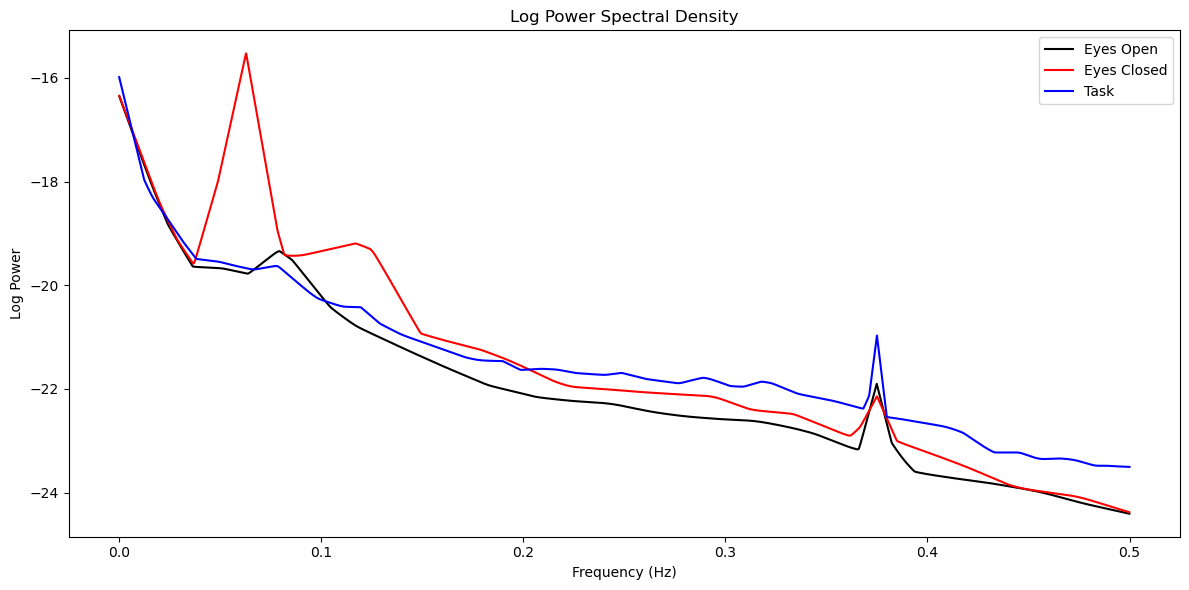

In [35]:
alpha_opt_lasso_o, freq_o = spectrum_estimator_lasso(y_o, 1000)
pgram_mean_lasso_o = (2/n_o)*(np.exp(2*alpha_opt_lasso_o))

alpha_opt_lasso_c, freq_c = spectrum_estimator_lasso(y_c, 1000)
pgram_mean_lasso_c = (2/n_c)*(np.exp(2*alpha_opt_lasso_c))

alpha_opt_lasso_t, freq_t = spectrum_estimator_lasso(y_t, 1000)
pgram_mean_lasso_t = (2/n_t)*(np.exp(2*alpha_opt_lasso_t))

plt.figure(figsize=(12, 6))
plt.plot(freq_o, np.log(pgram_mean_lasso_o), color='black', label='Eyes Open')
plt.plot(freq_c, np.log(pgram_mean_lasso_c), color='red', label='Eyes Closed')
plt.plot(freq_t, np.log(pgram_mean_lasso_t), color='blue', label='Task')
plt.legend()
plt.title("Log Power Spectral Density")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Log Power")
plt.tight_layout()
plt.show()

### Interpretation

From the combined plot, we observe several notable differences. The eyes closed condition shows a prominent peak around low frequencies (roughly 0.07 Hz), indicating stronger low-frequency oscillations when the eyes are shut. This aligns with known increases in alpha-band activity during rest. The task condition shows a broader, flatter spectrum with a distinct spike near 0.39 Hz, suggesting increased higher-frequency activity while performing a cognitive or motor task. The eyes open condition falls between the other two. While it lacks the strong low-frequency peak seen in the eyes-closed state, it also shows less power in the higher frequencies compared to the task condition. Overall, the spectral content varies systematically with condition: resting with eyes closed emphasizes low-frequency rhythms, the task condition shifts power toward higher frequencies, and eyes open (without task) appears more neutral in distribution.

## 2a)

  observation_date  POPTHM
0       1959-01-01  175818
1       1959-02-01  176044
2       1959-03-01  176274
3       1959-04-01  176503
4       1959-05-01  176723


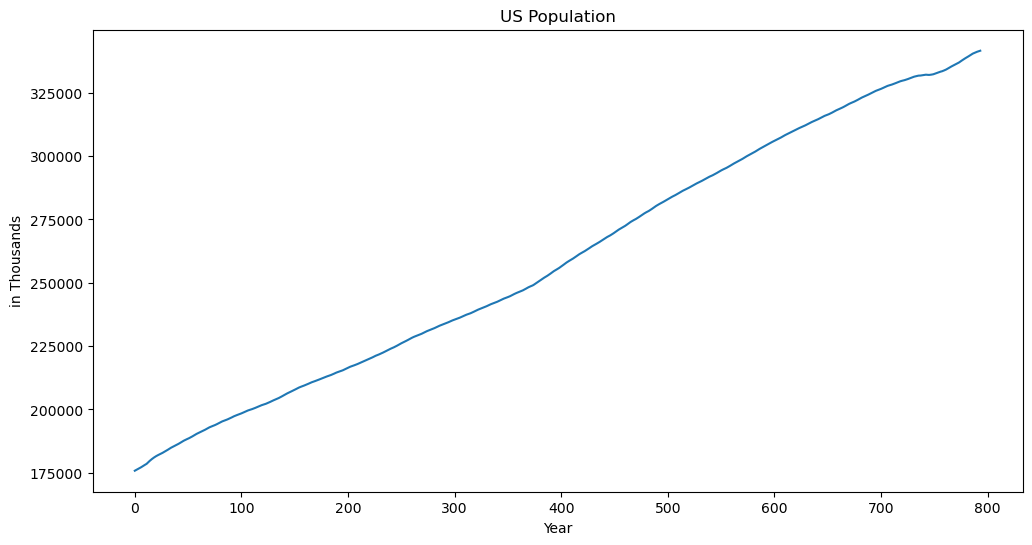

In [36]:
us_pop = pd.read_csv('POPTHM.csv')
print(us_pop.head())
y = us_pop['POPTHM'].to_numpy()
plt.figure(figsize = (12, 6))
plt.plot(y)
plt.xlabel('Year')
plt.ylabel('in Thousands')
plt.title('US Population')
plt.show()

In [37]:
p = 3
n = len(y)
yreg = y[p:] #these are the response values in the autoregression
Xmat = np.ones((n-p, 1)) #this will be the design matrix (X) in the autoregression
for j in range(1, p+1):
    col = y[p-j : n-j].reshape(-1, 1)
    Xmat = np.column_stack([Xmat, col])

armod = sm.OLS(yreg, Xmat).fit()
print(armod.params)
print(armod.summary())
sighat = np.sqrt(np.mean(armod.resid ** 2))
print(sighat)

[19.46675924  2.34270735 -1.77037035  0.42765616]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.517e+09
Date:                Sat, 12 Apr 2025   Prob (F-statistic):               0.00
Time:                        20:35:59   Log-Likelihood:                -3304.9
No. Observations:                 791   AIC:                             6618.
Df Residuals:                     787   BIC:                             6636.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
co

### Results

The estimated coefficients are:

$\phi_1 = 2.347 (SE = 0.032)$

$\phi_2 = 1.7704 (SE = 0.064)$

$\phi_3 = 0.4227 (SE = 0.032)$

## 2b)

  observation_date  POPTHM
0       1959-01-01  175818
1       1959-02-01  176044
2       1959-03-01  176274
3       1959-04-01  176503
4       1959-05-01  176723


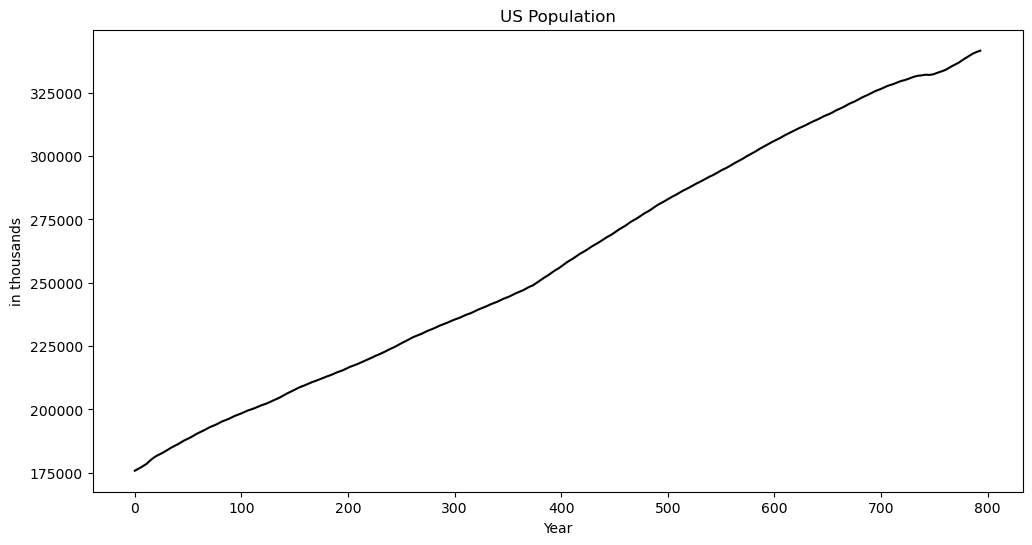

In [38]:
us_pop = pd.read_csv("POPTHM.csv")
print(us_pop.head())
y = us_pop['POPTHM']
plt.figure(figsize = (12, 6))
plt.plot(y, color = 'black')
plt.xlabel('Year')
plt.ylabel('in thousands')
plt.title('US Population')
plt.show()

In [39]:
n = len(y)
tme = range(1, n+1)
n_test = 60
n_train = n - n_test
y_train = y[:n_train]
tme_train = tme[:n_train]
y_test = y[n_train:]
tme_test = tme[n_train:]

In [40]:
p = 3
armod_sm = AutoReg(y_train, lags = p).fit()
print(armod_sm.summary())

                            AutoReg Model Results                             
Dep. Variable:                 POPTHM   No. Observations:                  734
Model:                     AutoReg(3)   Log Likelihood               -2986.787
Method:               Conditional MLE   S.D. of innovations             14.396
Date:                Sat, 12 Apr 2025   AIC                           5983.575
Time:                        20:35:59   BIC                           6006.547
Sample:                             3   HQIC                          5992.437
                                  734                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         19.1886      3.838      4.999      0.000      11.666      26.711
POPTHM.L1      2.3612      0.033     71.427      0.000       2.296       2.426
POPTHM.L2     -1.8147      0.065    -27.849      0.0

In [41]:
k = n_test
fcast = armod_sm.get_prediction(start = n_train, end = n_train+k-1)
fcast_mean = fcast.predicted_mean

In [42]:
#Predictions
yhat = np.concatenate([y_train.astype(float), np.full(k, -9999)]) #extend data by k placeholder values
phi_vals = armod_sm.params
for i in range(1, k+1):
    ans = phi_vals.iloc[0]
    for j in range(1, p+1):
        ans += phi_vals.iloc[j] * yhat[n_train+i-j-1]
    yhat[n_train+i-1] = ans
predvalues = yhat[n_train:]

#Check that both predictions are identical:
print(np.column_stack([predvalues, fcast_mean])[:5])

[[331611.77268413 331611.77268413]
 [331712.29864759 331712.29864759]
 [331829.38132677 331829.38132677]
 [331962.76382476 331962.76382475]
 [332110.8250194  332110.8250194 ]]


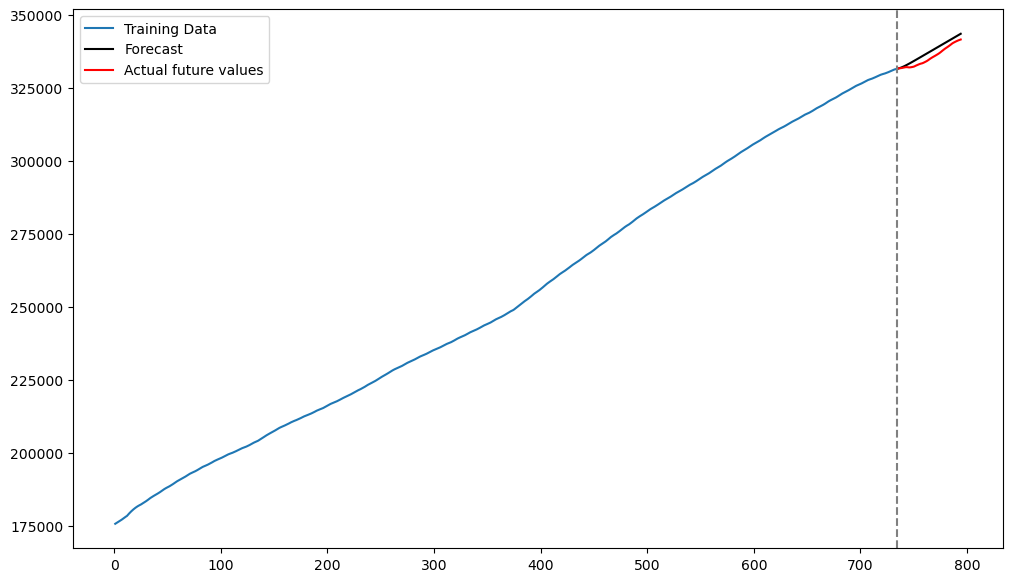

In [43]:
plt.figure(figsize = (12, 7))
plt.plot(tme_train, y_train, label = 'Training Data')
plt.plot(tme_test, fcast_mean, label = 'Forecast', color = 'black')
plt.plot(tme_test, y_test, color = 'red',  label = 'Actual future values')
plt.axvline(x=n_train, color='gray', linestyle='--')
plt.legend()
plt.show()

In [44]:
fcast_se = fcast.se_mean
alpha = 0.05
z_alpha_half = stats.norm.ppf(1 - alpha/2)
predlower = predvalues - z_alpha_half * fcast_se
predupper = predvalues + z_alpha_half * fcast_se
fcast_int = fcast.conf_int()
print(np.column_stack([predlower, predupper, fcast_int])[:5])

[[331583.55694192 331639.98842635 331583.55694192 331639.98842635]
 [331639.94664677 331784.6506484  331639.94664677 331784.6506484 ]
 [331700.95354572 331957.80910782 331700.95354572 331957.80910782]
 [331770.97851552 332154.54913399 331770.97851552 332154.54913399]
 [331851.88485216 332369.76518665 331851.88485216 332369.76518665]]


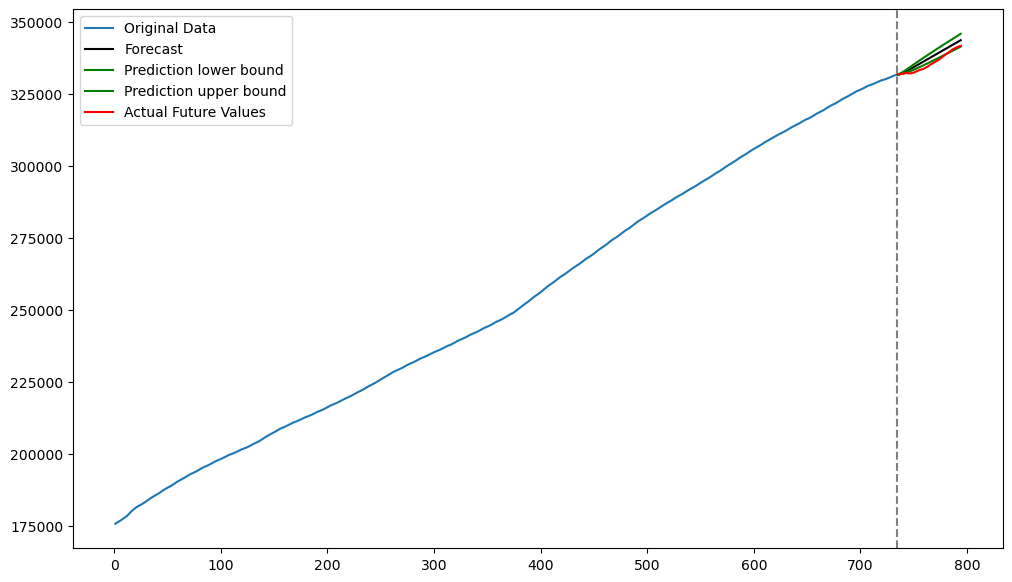

In [45]:
#Plotting predictions along with uncertainty:
plt.figure(figsize = (12, 7))
plt.plot(tme_train, y_train, label = 'Original Data')
plt.plot(tme_test, predvalues, label = 'Forecast', color = 'black')
plt.plot(tme_test, predlower, color = 'green', label = 'Prediction lower bound')
plt.plot(tme_test, predupper, color = 'green', label = 'Prediction upper bound')
plt.plot(tme_test, y_test, color = 'red', label = 'Actual Future Values')
plt.legend()
plt.axvline(x=n_train, color='gray', linestyle='--')
plt.show()

### Interpretation

To forecast the next 60 months of U.S. population growth, we fit an AR(3) model to the training data using the AutoReg class from statsmodels. The last 60 observations were held out for evaluation. Using the fitted AR model, we generated predictions along with 95% prediction intervals to quantify uncertainty.

The plot shows the original training data, the predicted future values, and the actual held-out values. The forecast tracks the actual data closely, and the prediction intervals widen appropriately as forecast horizon increases, reflecting greater uncertainty further into the future.

Overall, the forecasts are intuitively reasonable: they capture the upward trend in population and show only modest deviation from the true values, which fall comfortably within the uncertainty bounds. This indicates that the AR(3) model is a suitable choice for short- to medium-term forecasting of this time series.

## 2c)

In [46]:
n = len(y)
yresp = y[0:n-3]                     
Xmat = np.column_stack([             
    y[1:n-2],
    y[2:n-1],
    y[3:n]
])

# Add intercept term
Xmat = sm.add_constant(Xmat)

# Fit model
backward_model = sm.OLS(yresp, Xmat).fit()
print(backward_model.summary())

                            OLS Regression Results                            
Dep. Variable:                 POPTHM   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.524e+09
Date:                Sat, 12 Apr 2025   Prob (F-statistic):               0.00
Time:                        20:36:00   Log-Likelihood:                -3304.0
No. Observations:                 791   AIC:                             6616.
Df Residuals:                     787   BIC:                             6635.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -18.8330      3.934     -4.787      0.0

### Interpretation

The estimated coefficients and corresponding standard errors are:

$\alpha_0: -18.833 (SE = 3.934)$

$\alpha_1: 2.3406 (SE = 0.032)$

$\alpha_2: -1.7673 (SE = 0.063)$

$\alpha_0: 0.4627 (SE = 0.032)$

When compared to the AR(3) model estimated in part (a), the parameter estimates are nearly identical. This similarity suggests that the US population time series is highly autocorrelated and exhibits strong temporal smoothness, such that both forward and backward linear predictive models capture nearly the same relationships. 

## 2d)

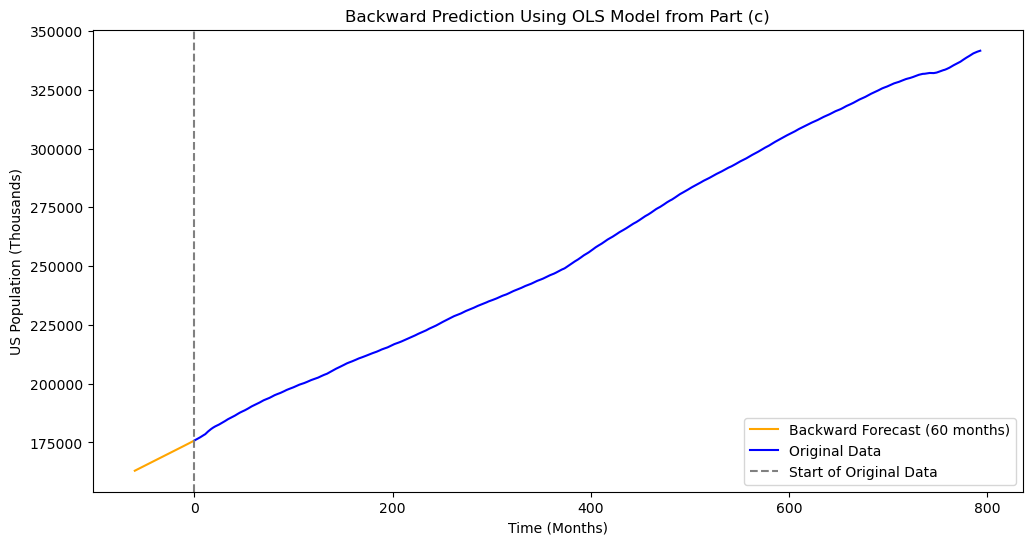

In [47]:
# Get coefficients from part (c)
coeffs = backward_model.params
alpha_0 = coeffs.iloc[0]
alpha = coeffs.iloc[1:]

# Step 1: Seed with first 3 observed values
known_future = list(y[:3])  # [y0, y1, y2]

# Step 2: Recursively generate 60 months of backward predictions
backward_preds = []
for _ in range(60):
    y_pred = alpha_0
    for j in range(3):
        y_pred += alpha.iloc[j] * known_future[j]
    backward_preds.append(y_pred)
    
    # Insert new prediction at front, shift future
    known_future = [y_pred] + known_future[:2]

# Step 3: Reverse to match timeline
backward_preds = backward_preds[::-1]

# Step 4: Plot
time_pred = np.arange(-60, 0)
plt.figure(figsize=(12, 6))
plt.plot(time_pred, backward_preds, label="Backward Forecast (60 months)", color="orange")
plt.plot(range(len(y)), y, label="Original Data", color="blue")
plt.axvline(x=0, color="gray", linestyle="--", label="Start of Original Data")
plt.title("Backward Prediction Using OLS Model from Part (c)")
plt.xlabel("Time (Months)")
plt.ylabel("US Population (Thousands)")
plt.legend()
plt.show()

### Interpretation

The backward forecast (orange line) continues a smooth and steady upward trajectory, consistent with the long-term trend in the observed US population data. Since population growth tends to be gradual and cumulative, this pattern is reasonable. The final predicted value (at time 0) connects well with the first actual data point in January 1959. This continuity suggests the model has captured the underlying dynamics reasonably well, it's not overshooting or undershooting dramatically.


## 3

  observation_date  MRTSSM4453USN
0       1992-01-01           1509
1       1992-02-01           1541
2       1992-03-01           1597
3       1992-04-01           1675
4       1992-05-01           1822


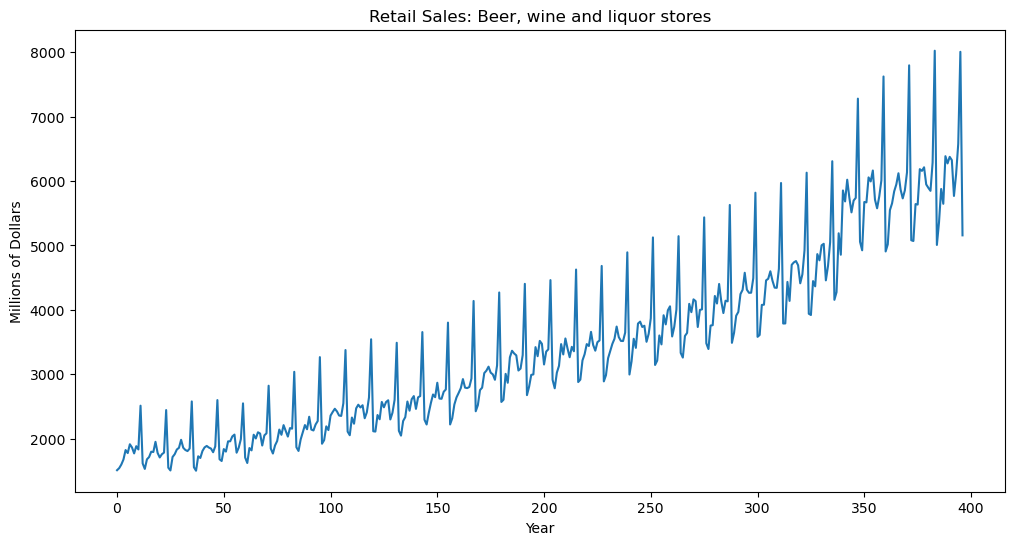

In [48]:
#The following is FRED data on retail sales (in millions of dollars) for beer, wine and liquor stores (https://fred.stlouisfed.org/series/MRTSSM4453USN)
beersales = pd.read_csv('MRTSSM4453USN.csv')
print(beersales.head())
y = beersales['MRTSSM4453USN'].to_numpy()
n = len(y)
plt.figure(figsize = (12, 6))
plt.plot(y)
plt.xlabel('Year')
plt.ylabel('Millions of Dollars')
plt.title('Retail Sales: Beer, wine and liquor stores')
plt.show()

In [49]:
n_test = 36
y_train = y[:-n_test]
y_test = y[-n_test:]

In [50]:
mse_list = []

for p in range(1, 25):
    model = AutoReg(y_train, lags=p).fit()
    predictions = model.predict(start=len(y_train), end=len(y)-1)
    mse = mean_squared_error(y_test, predictions)
    mse_list.append((p, mse))

In [51]:
best_p, best_mse = min(mse_list, key=lambda x: x[1])
print(f"Best AR({best_p}) model with MSE = {best_mse:.2f}")

Best AR(15) model with MSE = 68704.17


### Report

In [52]:
# Convert list of tuples to DataFrame
mse_df = pd.DataFrame(mse_list, columns=["p", "MSE"])

# Sort by p (optional, since loop is already in order)
mse_df = mse_df.sort_values(by="p").reset_index(drop=True)

# Display the full table
print(mse_df.to_string(index=False))

 p          MSE
 1 6.817927e+06
 2 3.850272e+06
 3 1.584950e+06
 4 7.145853e+05
 5 5.052283e+05
 6 5.394643e+05
 7 6.231229e+05
 8 6.551552e+05
 9 6.804042e+05
10 6.224806e+05
11 6.662709e+05
12 4.198162e+05
13 2.764941e+05
14 1.383150e+05
15 6.870417e+04
16 1.153138e+05
17 1.804502e+05
18 2.302323e+05
19 2.811342e+05
20 3.146215e+05
21 2.871490e+05
22 2.771583e+05
23 2.804452e+05
24 2.701240e+05


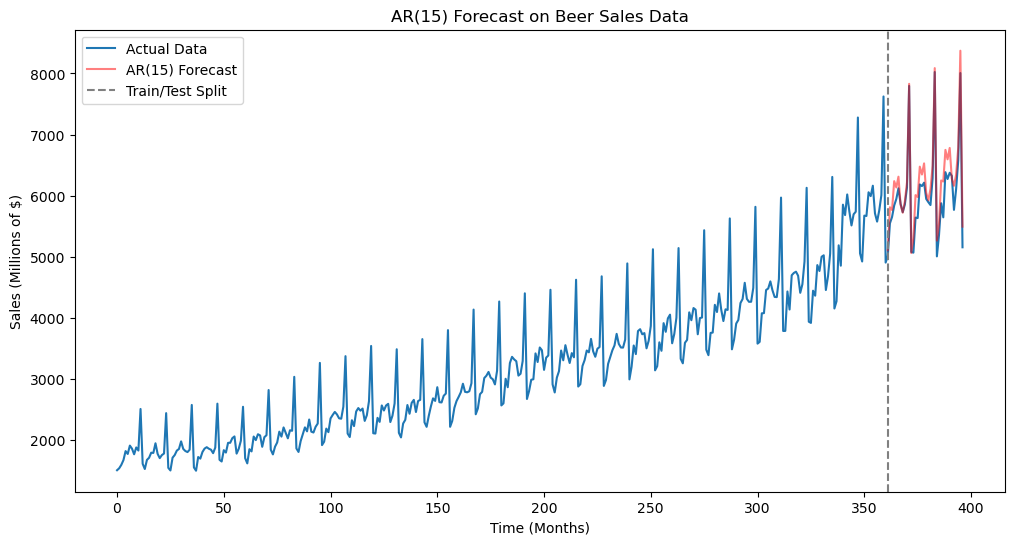

In [53]:
best_model = AutoReg(y_train, lags=best_p).fit()
best_pred = best_model.predict(start=len(y_train), end=len(y)-1)

plt.figure(figsize=(12,6))
plt.plot(range(len(y)), y, label='Actual Data')
plt.plot(range(len(y)-n_test, len(y)), best_pred, color='red',alpha = 0.5, label=f'AR({best_p}) Forecast')
plt.axvline(x=len(y)-n_test, color='gray', linestyle='--', label='Train/Test Split')
plt.legend()
plt.title(f"AR({best_p}) Forecast on Beer Sales Data")
plt.xlabel("Time (Months)")
plt.ylabel("Sales (Millions of $)")
plt.show()

### Comments

The MSE results are summarized in the table above. Among all models, AR(15) achieved the lowest MSE, indicating the best performance in terms of forecast accuracy on the held-out data. This suggests that including the previous 15 lags provides the optimal balance between capturing relevant temporal dependencies and avoiding overfitting.

The forecast from the AR(15) model is plotted alongside the actual test data. The prediction tracks the observed values closely, capturing both the trend and seasonal variation present in the sales data. The moderate transparency of the forecast line allows for easy comparison with actual outcomes and reveals that the AR(15) model generally performs well across the test period.

In conclusion, the AR(15) model provides a strong fit to the data and produces reliable forecasts over the test horizon, making it the preferred model for this task.

## 4a)

  observation_date   PCESV
0       1947-01-01  60.567
1       1947-04-01  61.783
2       1947-07-01  63.124
3       1947-10-01  64.219
4       1948-01-01  65.279


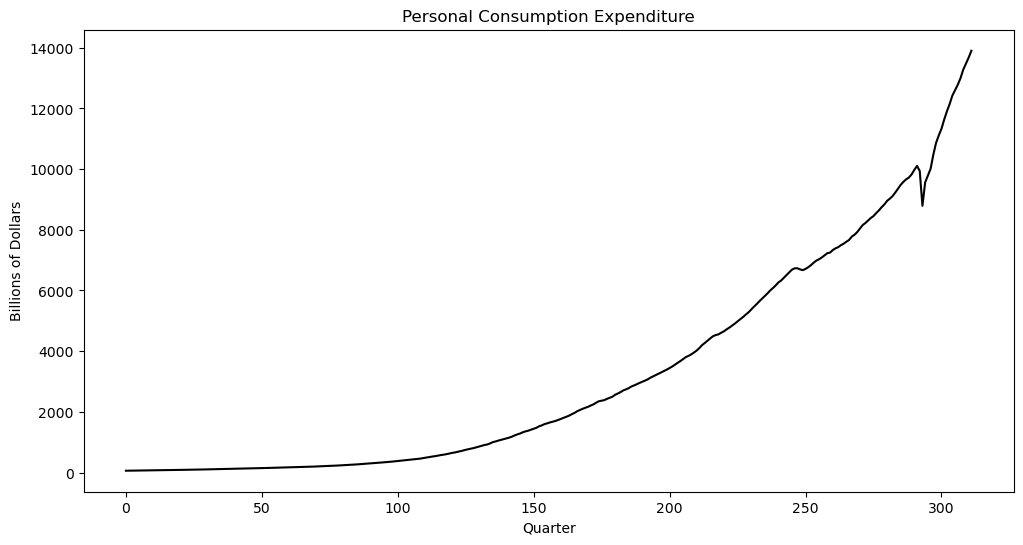

In [54]:
pcec = pd.read_csv("PCESV.csv")
print(pcec.head())
y = pcec['PCESV']
plt.figure(figsize = (12, 6))
plt.plot(y, color = 'black')
plt.xlabel('Quarter')
plt.ylabel('Billions of Dollars')
plt.title('Personal Consumption Expenditure')
plt.show()

In [55]:
n = len(y)
tme = range(1, n+1)
n_test = 24
n_train = n - n_test
y_train = y[:n_train]
tme_train = tme[:n_train]
y_test = y[n_train:]
tme_test = tme[n_train:]

In [56]:
p = 3
armod_sm = AutoReg(y_train, lags = p).fit()
print(armod_sm.summary())

                            AutoReg Model Results                             
Dep. Variable:                  PCESV   No. Observations:                  288
Model:                     AutoReg(3)   Log Likelihood               -1126.230
Method:               Conditional MLE   S.D. of innovations             12.588
Date:                Sat, 12 Apr 2025   AIC                           2262.460
Time:                        20:36:00   BIC                           2280.723
Sample:                             3   HQIC                          2269.781
                                  288                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.6951      1.082      2.490      0.013       0.574       4.816
PCESV.L1       1.6099      0.059     27.239      0.000       1.494       1.726
PCESV.L2      -0.5007      0.109     -4.614      0.0

### Conclusion

After running a summary, we achieved the following results: 

$\phi_0$(Intercept)-	Estimate - 2.6951 Standard Error- 1.082

$\phi_1$- Estimate: 1.6099 Standard Error: 0.059

$\phi_2$- Estimate: -0.5007 Standard Error: 0.109

$\phi_3$- Estimate: -0.1063 Standard Error: 0.060


We fit an AR(p) model to the training data, where $\text{PCE}_t$ represents personal consumption expenditure. To determine the optimal order $p$, we applied a confidence interval-based heuristic: starting at $p=1$, we increased $p$ incrementally and checked whether the 95% confidence interval for the last autoregressive coefficient $\phi$ included zero. If the interval included zero, the corresponding coefficient was deemed statistically insignificant, and we stopped increasing $p$. At $p=3$, the confidence interval for $\phi_3$ was [−0.223, 0.011], which contains zero, suggesting that this term is not statistically significant. Therefore, the best model is AR(2), using only the first two lags.

## 4b)

In [57]:
p = 2
armod_sm = AutoReg(y_train, lags = p).fit()
print(armod_sm.summary())

                            AutoReg Model Results                             
Dep. Variable:                  PCESV   No. Observations:                  288
Model:                     AutoReg(2)   Log Likelihood               -1131.286
Method:               Conditional MLE   S.D. of innovations             12.637
Date:                Sat, 12 Apr 2025   AIC                           2270.572
Time:                        20:36:00   BIC                           2285.196
Sample:                             2   HQIC                          2276.434
                                  288                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.9500      1.072      2.753      0.006       0.850       5.050
PCESV.L1       1.6807      0.044     38.162      0.000       1.594       1.767
PCESV.L2      -0.6775      0.044    -15.230      0.0

In [58]:
k = 24
fcast = armod_sm.get_prediction(start = n_train, end = n_train + k - 1)
fcast_mean = fcast.predicted_mean # this gives the point predictions

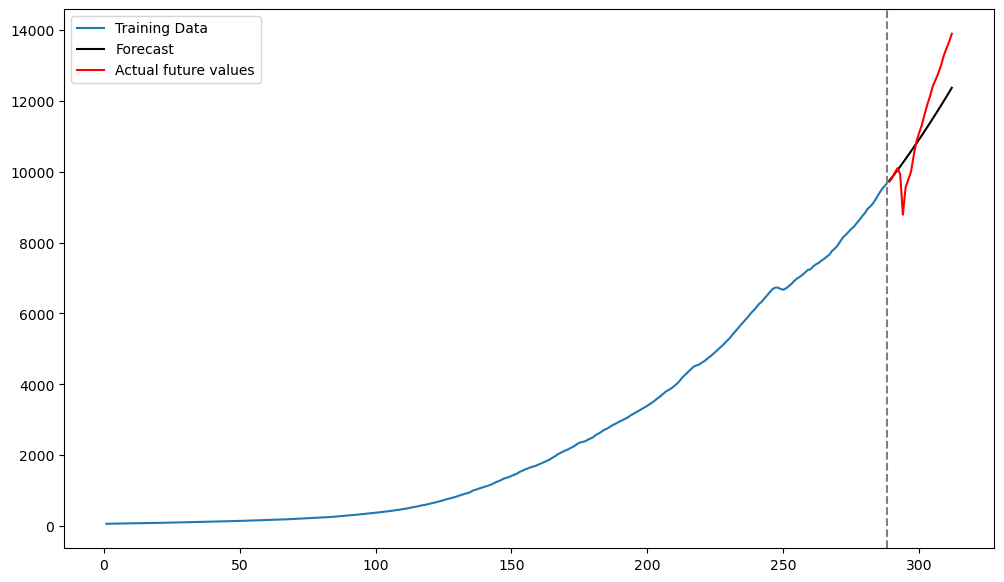

In [59]:
plt.figure(figsize = (12, 7))
plt.plot(tme_train, y_train, label = 'Training Data')
plt.plot(tme_test, fcast_mean, label = 'Forecast', color = 'black')
plt.plot(tme_test, y_test, color = 'red', label = 'Actual future values')
plt.axvline(x=n_train, color='gray', linestyle='--')
plt.legend()
plt.show()

### Conclusion

From the plot, we observe that the AR(2) model captures the overall upward trend in personal consumption expenditures but fails to closely track the recent curvature and variability present in the test data. Specifically, the forecast underestimates some of the sharp increases observed in the actual values, particularly in the latter part of the test window. This discrepancy is likely due to the model’s reliance on linear combinations of past values, which may not fully account for recent accelerations in growth.

While the model offers a reasonable directional forecast, the accuracy diminishes as we move further from the training period, highlighting the limitations of using low-order AR models for highly non-linear or rapidly evolving time series.

## 4c)

In [60]:
ylog_train = np.log(y_train)
ylog_test = np.log(y_test)

In [61]:
p = 4
armod_sm = AutoReg(ylog_train, lags = p).fit()
print(armod_sm.summary())

                            AutoReg Model Results                             
Dep. Variable:                  PCESV   No. Observations:                  288
Model:                     AutoReg(4)   Log Likelihood                1097.965
Method:               Conditional MLE   S.D. of innovations              0.005
Date:                Sat, 12 Apr 2025   AIC                          -2183.930
Time:                        20:36:01   BIC                          -2162.036
Sample:                             4   HQIC                         -2175.152
                                  288                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0070      0.002      3.518      0.000       0.003       0.011
PCESV.L1       1.3889      0.059     23.662      0.000       1.274       1.504
PCESV.L2      -0.1513      0.101     -1.498      0.1

### Results

After running a summary, we achieved the following results: 

$\phi_0$(Intercept)-Estimate: 0.0070 Standard Error 0.002

$\phi_1$- Estimate: 1.3899 Standard Error: 0.059

$\phi_2$- Estimate: -0.1513 Standard Error: 0.101

$\phi_3$- Estimate: -0.0937 Standard Error: 0.101

$\phi_4$- Estimate: -0.1444 Standard Error: 0.059

## 4d)

In [62]:
k = 24
fcast = armod_sm.get_prediction(start = n_train, end = n_train + k - 1)
fcast_mean = fcast.predicted_mean # this gives the point predictions

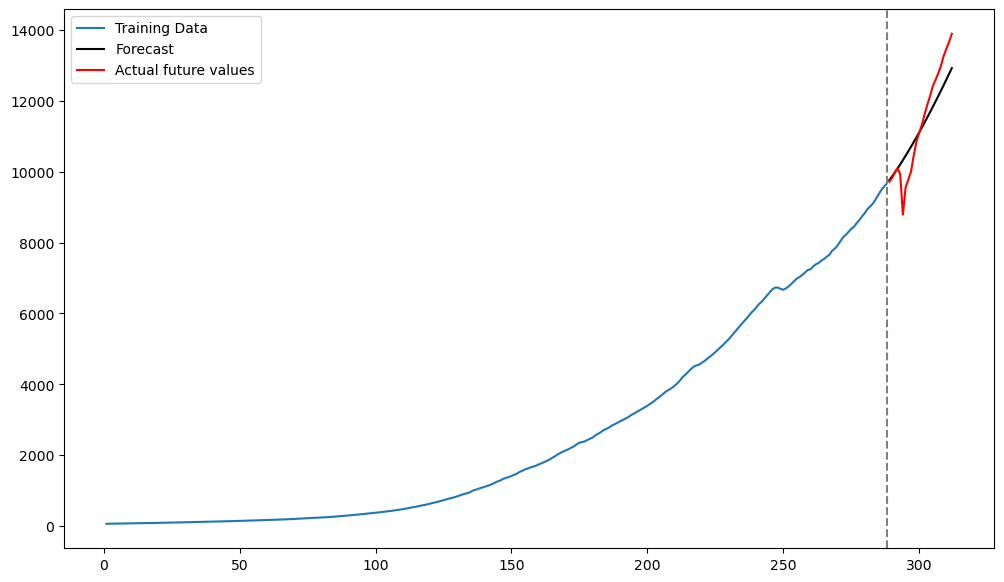

In [63]:
plt.figure(figsize = (12, 7))
plt.plot(tme_train, y_train, label = 'Training Data')
plt.plot(tme_test, np.exp(fcast_mean), label = 'Forecast', color = 'black') # Note the exponentiation
plt.plot(tme_test, y_test, color = 'red',  label = 'Actual future values')
plt.axvline(x=n_train, color='gray', linestyle='--')
plt.legend()
plt.show()

### Conclusion

The AR(4) model fitted on the log-transformed data (Model Two) provides forecasts that appear smoother and more consistent with the overall growth trend compared to the model fitted on the original (non-log) data (Model One). After exponentiating the forecasts to return to the original scale, the predictions from Model Two better capture the general direction of the actual test values, particularly the accelerating growth in the latter part of the series.

However, despite improved alignment in trend, the forecasts from Model Two still underestimate some of the sharp increases in the actual values. This suggests that while taking logs helped stabilize the variance and improved trend matching, the AR(4) model still lacks flexibility to capture sudden, nonlinear surges in consumption.

## 4e)

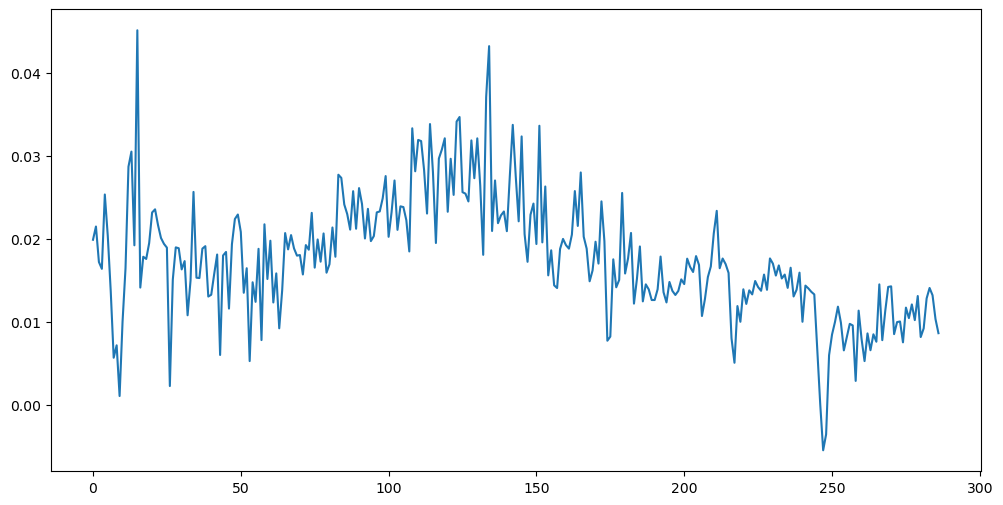

In [64]:
ylogdiff_train = np.diff(ylog_train)

plt.figure(figsize = (12, 6))
plt.plot(ylogdiff_train) 
plt.show()

In [65]:
max_p = 20
p = 1
while p <= max_p:
    armd = AutoReg(ylogdiff_train, lags = p).fit()
    conf_ints = armd.conf_int(alpha = 0.05)
    lower, upper = conf_ints[-1, :]
    if (lower < 0 < upper):
        print(f"Stopping at p = {p} because 0 is in the phi_{p} interval")
        break
    p += 1
if p >= max_p:
    print(f"Reached p = {max_p} without finding a phi_p interval containing 0")
p = p-1 #note that if the algorithm outputs p = 4, we should take p = 3

print(p)

Stopping at p = 4 because 0 is in the phi_4 interval
3


In [66]:
armod_sm = AutoReg(ylogdiff_train, lags = p, trend = 'c').fit()
print(armod_sm.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  287
Model:                     AutoReg(3)   Log Likelihood                1095.738
Method:               Conditional MLE   S.D. of innovations              0.005
Date:                Sat, 12 Apr 2025   AIC                          -2181.477
Time:                        20:36:01   BIC                          -2163.232
Sample:                             3   HQIC                         -2174.162
                                  287                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0032      0.001      3.627      0.000       0.001       0.005
y.L1           0.4055      0.059      6.915      0.000       0.291       0.520
y.L2           0.2511      0.062      4.078      0.0

In [67]:
phi_vals = np.array([armod_sm.params[0], armod_sm.params[1] + 1, 
                     armod_sm.params[2] - armod_sm.params[1],armod_sm.params[3] -armod_sm.params[2],
                    -armod_sm.params[3]]) 
# these are the fitted coefficients in the AR(4) model derived from AR(3) applied to the differences
armod_nodiff = AutoReg(ylog_train, lags = 4).fit()
print(np.column_stack([phi_vals, armod_nodiff.params]))

[[ 0.00322326  0.0070065 ]
 [ 1.40545096  1.38888374]
 [-0.15434679 -0.15125232]
 [-0.09275683 -0.0937163 ]
 [-0.15834734 -0.14435258]]


### Results

The coefficients from both models are very close in value. The intercepts differ slightly but are still within a small margin. All four AR coefficients are quite similar in magnitude and sign. This suggests that the AR(3) model on the differenced data, when rewritten as an AR(4) on $log(PCE_t)$, captures nearly the same dynamics as the AR(4) fitted directly on the level data.

## 4f)

In [150]:
k = 24
fcast = armod_sm.get_prediction(start = n_train - 1, end = n_train + k - 2)
fcast_mean = fcast.predicted_mean # this gives the point predictions

In [151]:
last_observed_log = ylog_train.iloc[-1]
log_forecast = np.zeros(k)
log_forecast[0] = last_observed_log + fcast_mean[0]
for i in range(1, k):
    log_forecast[i] = log_forecast[i - 1] + fcast_mean[i]
original_scale_forecast = np.exp(log_forecast)

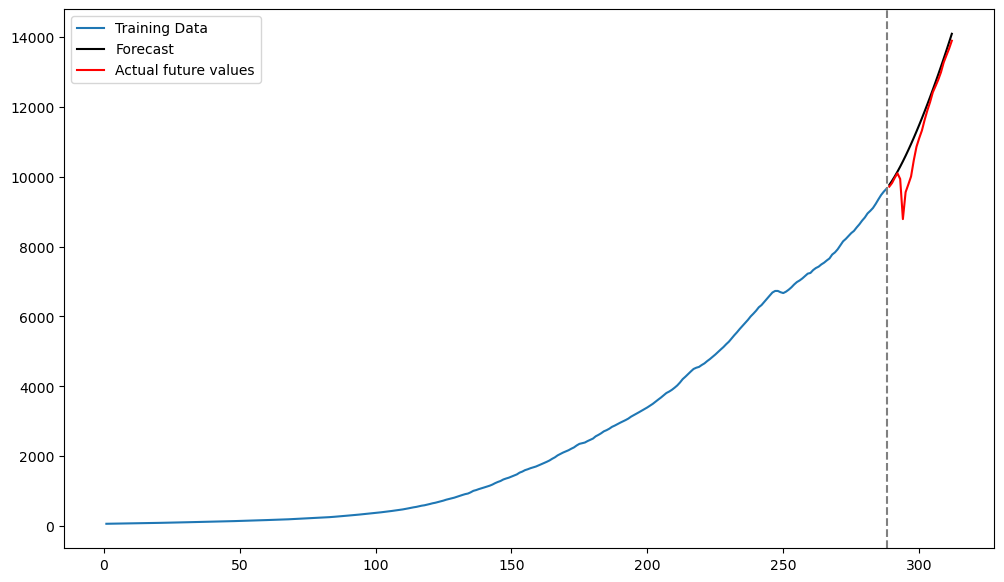

In [152]:
plt.figure(figsize = (12, 7))
plt.plot(tme_train, y_train, label = 'Training Data')
plt.plot(tme_test, original_scale_forecast, label = 'Forecast', color = 'black')
plt.plot(tme_test, y_test, color = 'red',  label = 'Actual future values')
plt.axvline(x=n_train, color='gray', linestyle='--')
plt.legend()
plt.show()

### Interpreation

The predictions from the AR(3) model fitted to the differenced log(PCEₜ) data are noticeably more accurate than those from previous models. The forecasted values (in black) closely follow the actual test values (in red), capturing both the overall growth trend and local fluctuations more effectively. 

## 4g)

In [153]:
ylogdiff_train = np.diff(ylog_train)
armod_sm = AutoReg(ylogdiff_train, lags=2, trend='c').fit()
print(armod_ddiff.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  286
Model:                     AutoReg(2)   Log Likelihood                1088.234
Method:               Conditional MLE   S.D. of innovations              0.005
Date:                Sat, 12 Apr 2025   AIC                          -2168.468
Time:                        21:38:02   BIC                          -2153.872
Sample:                             2   HQIC                         -2162.616
                                  286                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -5.632e-05      0.000     -0.181      0.856      -0.001       0.001
y.L1          -0.5306      0.058     -9.175      0.000      -0.644      -0.417
y.L2          -0.2232      0.058     -3.859      0.0

In [154]:
phi_vals = np.array([
    armod_ddiff.params[0],                              
    armod_ddiff.params[1] + 2 + 1,                     
    armod_ddiff.params[2] - 2*armod_ddiff.params[1],    
    -2*armod_ddiff.params[2] + armod_ddiff.params[1],   
    armod_ddiff.params[2]                               
])
armod_nodiff = AutoReg(ylog_train, lags = 4).fit()
print(np.column_stack([phi_vals, armod_nodiff.params]))

[[-5.63162898e-05  7.00649999e-03]
 [ 2.46943451e+00  1.38888374e+00]
 [ 8.37915844e-01 -1.51252321e-01]
 [-8.41352166e-02 -9.37163022e-02]
 [-2.23215137e-01 -1.44352584e-01]]


The estimated coefficients from the AR(4) model derived from the double-differenced log data differ significantly from those in the AR(4) model fitted to the original $log(PCE_t)$ data. In particular, the lag-1 and lag-2 coefficients are quite different in both magnitude and sign. 

## 4h)

In [159]:
fcast = armod_sm.get_prediction(start=n_train - 1, end=n_train + k - 1)
fcast_mean = fcast.predicted_mean

In [160]:
# Step 1: Integrate second differences to get first differences
logdiff_forecast = np.zeros(k)
logdiff_forecast[0] = ylogdiff_train[-1]  # just copy the last known first difference
for i in range(1, k):
    logdiff_forecast[i] = logdiff_forecast[i - 1] + fcast_mean[i]

loglevel_forecast = np.zeros(k)
loglevel_forecast[0] = ylog_train.iloc[-1] + fcast_mean[0]  # start from last log value
for i in range(1, k):
    loglevel_forecast[i] = loglevel_forecast[i - 1] + fcast_mean[i]

# Step 4: Back-transform to original scale
original_scale_forecast = np.exp(loglevel_forecast)

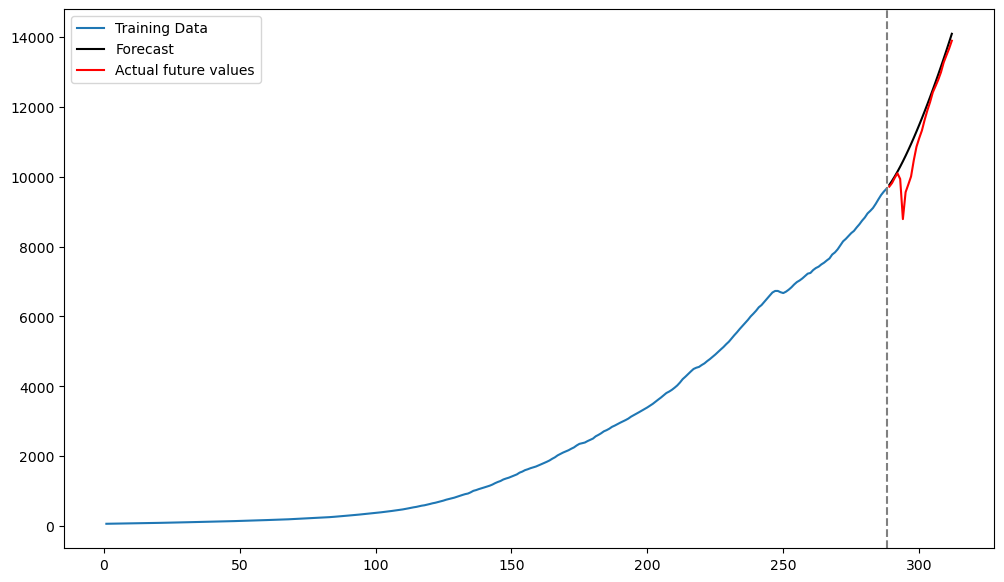

In [161]:
plt.figure(figsize = (12, 7))
plt.plot(tme_train, y_train, label = 'Training Data')
plt.plot(tme_test, original_scale_forecast, label = 'Forecast', color = 'black')
plt.plot(tme_test, y_test, color = 'red',  label = 'Actual future values')
plt.axvline(x=n_train, color='gray', linestyle='--')
plt.legend()
plt.show()

### Comments

The AR(2) model fitted to the double-differenced log-transformed data yields predictions that closely follow the overall trend of the actual test observations. The black forecast curve exhibits smooth and consistent growth, successfully capturing the long-term trajectory seen in the red actual values. While the forecast slightly underestimates the short-term variability (especially during local dips), it still aligns well with the test data in scale and shape. Overall, the prediction is accurate and stable, particularly for capturing sustained growth patterns in the series.

## 4i)

## Conclusion

The AR(3) model fitted to the differenced log(PCE) data gave the best predictions for the 24 test observations.

This can be seen in part 4h, where the forecasted values (in black) closely track the actual test values (in red), capturing both the overall trend and local variations. The predictions are visually more accurate and stable compared to earlier models, especially the exponentially diverging forecasts from earlier attempts.

## 5a)

We are given the second-order difference equation:
$$u_k - u_{k-1} + \frac{1}{2}u_{k-2} = 0, \quad \text{for } k = 0, 1, 2, \dots$$


and asked to show that the solution is given by:

$$u_k = 2^{-k/2} \left( u_0 \cos\left(\frac{\pi k}{4}\right) + (2u_1 - u_0) \sin\left(\frac{\pi k}{4}\right) \right)$$


We consider a solution of the form:

$$u_k = r^k \left( A \cos(\omega k) + B \sin(\omega k) \right)$$
for constants $r$ and  $\omega$ to be determined.

$$u_k r^k \left( A \cos(\omega k) + B \sin(\omega k) \right)$$

$$u_{k-1} r^{k-1} \left( A \cos(\omega(k - 1)) + B \sin(\omega(k - 1)) \right)$$
$$u_{k-2} r^{k-2} \left( A \cos(\omega(k - 2)) + B \sin(\omega(k - 2)) \right)$$
Substitute into the difference equation:

$$u_k - u_{k-1} + \frac{1}{2} u_{k-2} = 0$$

Factoring out $r^{k-2}$, we obtain:

$$r^{k-2} \left[ r^2 (A \cos(\omega k) + B \sin(\omega k)) 
- r (A \cos(\omega(k - 1)) + B \sin(\omega(k - 1))) 
+ \frac{1}{2} (A \cos(\omega(k - 2)) + B \sin(\omega(k - 2))) \right] = 0$$

This equation will hold for all $k$ if the bracketed expression is zero. Choosing $$r = 2^{-1/2}$$ Thus, $$\text{the trigonometric terms} \, \, r^2 = \frac{1}{2}, \text{and} \, \, \omega = \frac{\pi}{4}, \text{satisfy the recurrence}$$.

Let,
$$u_k = 2^{-k/2} \left( A \cos\left(\frac{\pi k}{4} \right) + B \sin\left( \frac{\pi k}{4} \right) \right)$$

$$u_0 = A$$
$$u_1 = 2^{-1/2} \left( A \cos\left( \frac{\pi}{4} \right) + B \sin\left( \frac{\pi}{4} \right) \right)
= \frac{1}{\sqrt{2}} (A + B)$$

$$A = u_0$$,
$$B = 2u_1 - u_0$$

$$u_k = 2^{-k/2} \left( u_0 \cos\left(\frac{\pi k}{4} \right) + (2u_1 - u_0) \sin\left(\frac{\pi k}{4} \right) \right)$$
which verifies the proposed expression.

## 5b)

We are given the AR(2) model:
$$y_t = 3 + y_{t-1} - 0.5 y_{t-2} + \epsilon_t$$

We subtract the constant to isolate the homogeneous difference equation:
$$u_t = y_t - 6 \quad \Rightarrow \quad u_t = u_{t-1} - 0.5 u_{t-2}$$

This is a linear homogeneous second-order difference equation. We look for solutions of the form:

$$u_k = r^k$$

Substituting into the recurrence:
$$r^t = r^{t-1} - 0.5 r^{t-2} \rightarrow \quad r^2 = r - 0.5$$



Solving the quadratic:
$$r = \frac{1 \pm i}{2} = \frac{1}{\sqrt{2}} e^{\pm i\pi/4}$$

So the general solution is:
$$u_k = 2^{-k/2} \left( A \cos\left( \frac{\pi k}{4} \right) + B \sin\left( \frac{\pi k}{4} \right) \right)$$

We match:
$$u_{1} = y_n \, \, \text{and} \, \, u_0 = y_{n-1} $$

$$u_0 = A$$
$$u_1 = 2^{-1/2} (A \cos(\pi/4) + B \sin(\pi/4)) = \frac{1}{\sqrt{2}} (A + B)$$

Solving:

$$A = y_{n-1} - 6$$
$$B = 2(y_n - 6) - (y_{n-1} - 6) = 2y_n - y_{n-1} - 6$$

Now we plug $A$ and $B$ back into the general solution:

$$\hat{y}_{n+i} = 6 + u_{i+1}$$

$$= 6 + 2^{-(i+1)/2} \left( (y_{n-1}) \cos\left( \frac{\pi(i+1)}{4} \right) + (2y_n - y_{n-1}) \sin\left( \frac{\pi(i+1)}{4} \right) \right)$$

This confirms the required prediction formula

## 5c)

$$y_t = 6 + \sum_{j=0}^\infty \theta_j \varepsilon_{t-j}, \quad \text{where } \theta_j = 2^{-j/2}\left( \cos\left(\frac{\pi j}{4}\right) + \sin\left(\frac{\pi j}{4}\right) \right), \quad \varepsilon_t \sim \text{i.i.d. } N(0, \sigma^2)$$

Let $z_t = y_t - 6 = \sum_{j=0}^\infty \theta_j \varepsilon_{t-j}$

Now we compute $z_{t-1}$ and $z_{t-2}$:

$$z_{t-1} = \sum_{j=0}^\infty \theta_j \varepsilon_{t-1-j} = \sum_{j=1}^\infty \theta_{j-1} \varepsilon_{t-j}$$
    $$z_{t-2} = \sum_{j=0}^\infty \theta_j \varepsilon_{t-2-j} = \sum_{j=2}^\infty \theta_{j-2} \varepsilon_{t-j}$$

$$z_{t-1} - 0.5 z_{t-2} = \sum_{j=1}^\infty (\theta_{j-1} - 0.5 \theta_{j-2}) \varepsilon_{t-j}$$

We now compute $z_t - \varepsilon_t = \sum_{j=1}^\infty \theta_j \varepsilon_{t-j}$.
To prove:

$$z_t = \varepsilon_t + z_{t-1} - 0.5 z_{t-2}$$

we check that $\theta_j$ satisfies:
$$\theta_j = \theta_{j-1} - 0.5 \theta_{j-2}, \quad j \geq 2$$

which it does (as shown in part (b)). Hence:  $$y_t = 6 + z_t = 6 + \varepsilon_t + z_{t-1} - 0.5 z_{t-2} = 3 + y_{t-1} - 0.5 y_{t-2} + \varepsilon_t$$
Therefore, the given moving average representation satisfies the AR(2) model.

## 6a)

By linearity of expectation and the independence of the $U$ and $V$ terms:

$$\mathbb{E}[y_t] = \mathbb{E}[U_1] \cos(2\pi f_1 t) + \mathbb{E}[V_1] \sin(2\pi f_1 t) + \mathbb{E}[U_2] \cos(2\pi f_2 t) + \mathbb{E}[V_2] \sin(2\pi f_2 t) = 0 + 0 + 0 + 0 = 0$$

## 6b)

Since the coefficients are i.i.d. with variance $\sigma^2$, and using the independence of all components:

$$\operatorname{Var}(y_t) = \sigma^2 \cos^2(2\pi f_1 t) + \sigma^2 \sin^2(2\pi f_1 t) + \sigma^2 \cos^2(2\pi f_2 t) + \sigma^2 \sin^2(2\pi f_2 t) = \sigma^2 (\cos^2 + \sin^2) + \sigma^2 (\cos^2 + \sin^2) = \sigma^2(1 + 1) = 2\sigma^2$$

## 6c)

We compute:

$$\operatorname{Cov}(y_{t_1}, y_{t_2}) = \mathbb{E}[y_{t_1} y_{t_2}] - \mathbb{E}[y_{t_1}] \mathbb{E}[y_{t_2}] = \mathbb{E}[y_{t_1} y_{t_2}]$$

where:

$$y_{t_1} y_{t_2} = \sum_{i=1}^2 \left[ U_i^2 \cos(2\pi f_i t_1) \cos(2\pi f_i t_2) + V_i^2 \sin(2\pi f_i t_1) \sin(2\pi f_i t_2) \right]$$

So, taking expectations:

$$\operatorname{Cov}(y_{t_1}, y_{t_2}) = \sum_{i=1}^2 \sigma^2 \left[ \cos(2\pi f_i t_1) \cos(2\pi f_i t_2) + \sin(2\pi f_i t_1) \sin(2\pi f_i t_2) \right] = \sum_{i=1}^2 \sigma^2 \cos\left( 2\pi f_i (t_1 - t_2) \right)$$

## 6d)

Yes, the process $y_t$ is stationary. The mean $\mathbb{E}[y_t]$ is constant over all time points. The covariance $\operatorname{Cov}(y_t, y_s)$ depends only on the time difference $|t−s|$, not on $t$ or $s$ individually.